# 이해를 위한 정리

* $AQ = F$
* $Q = A^{-1}F$
* $A^TAQ = A^TF  \to Q = (A^TA)^{-1}A^TF$
* $\alpha Q_\alpha + A^TAQ_\alpha = A^TF \to Q_\alpha = (\alpha I + A^TA)^{-1} A^TF$


---




 ## $Q_\alpha = (\alpha I + A^TA)^{-1} A^TF$

 or

 ## $Q_n = \frac{F_n}{\alpha e^{n^2T} + e^{-n^2T}}, \quad\quad n = 1, 2, \cdots , N$



```
invA = np.diag(1/(alpha*np.exp((np.arange(1, N+1))**2*T)+np.exp(-(np.arange(1, N+1))**2*T)))
hatQ = invA@F
```



# Generate Data 


*   generate_Q
*   sol_act
*   noise_data
*   sol_Tik
*   result_gen_data
*   result_Lcurve



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

T = 1
delta = 0.01
N = 10
M = 50000
tau = 1
min_al = -20

In [2]:
def generate_Q(N,  M, tau):
    ii = 0
    tore = tau*np.sqrt(2/np.pi)
    Q = []
    while ii < M:
        tempQ = 2*tore*np.random.rand(N) - tore
        tempQ = np.array(tempQ)
        if np.linalg.norm(tempQ) <= tore:
            Q = np.append(Q, tempQ)
            ii += 1
    return (Q.reshape(-1, N))

def sol_act(Q, T):
    A = np.diag(np.exp(-(np.arange(1, N+1))**2*T))
    F = A@Q.T #A = NxN, Q = MxN, Q.T = NxM , F = NxM
    return F

def noise_data(F, delta):
    e = 2*np.random.rand(len(F[:,0]), len(F[0])) - 1
    N = len(F[:])
    for m in range(len(F[0])):
        norm = np.linalg.norm(F[:,m])
        e[:, m] = e[:, 0]*norm*delta
    nF = F+e
    return nF

def sol_Tik(alpha, T, F):
    invA = np.diag(1/(alpha*np.exp((np.arange(1, N+1))**2*T)+np.exp(-(np.arange(1, N+1))**2*T))) # A = NxN
    hatQ = invA@F 
    return hatQ

def result_gen_data(Q, F, nF, N, M, tau, delta):
    #Q = generate_Q(N, M, tau)
    #T = 1
    #F = sol_act(Q, T)
    #nF = noise_data(F, delta)
    np.savetxt('Q.txt', Q.T, fmt='%8f', delimiter = ',', header='')
    np.savetxt('F.txt', F, fmt='%8f', delimiter = ',', header='')
    np.savetxt('nF.txt', nF, fmt='%8f', delimiter = ',', header='')

In [3]:
Q = generate_Q(N, M, tau = 1)
F = sol_act(Q, T)
nF = noise_data(F, delta)
result_gen_data(Q, F, nF, N, M, tau = 1, delta = 0.01)
F

array([[-7.75709864e-02, -7.23804864e-02,  1.50323921e-02, ...,
         8.36931006e-02,  6.17601047e-02, -2.56411939e-02],
       [-3.22308238e-03, -2.84937513e-03, -1.11542604e-03, ...,
         4.63299638e-04, -9.05587203e-03, -6.68176868e-03],
       [-5.33751626e-05,  3.23409553e-06, -5.45812913e-05, ...,
         4.93432324e-05, -7.19757645e-06,  6.64669851e-06],
       ...,
       [-1.82411933e-29,  4.14275150e-29,  6.61816817e-29, ...,
        -9.49534791e-30, -6.16840956e-29, -5.50367759e-29],
       [-1.22724684e-36, -8.19415474e-37,  9.22483990e-37, ...,
         3.47526993e-37, -1.02279953e-37, -1.25097770e-36],
       [ 3.52207175e-45, -7.91788353e-45, -9.79990118e-45, ...,
         1.16079822e-44,  7.67933728e-45,  1.60739102e-44]])

## v[i]$\bullet$v[i+k] 사용하여 cos 구하기

In [4]:
def find_best_idx(log_x2, log_y2):
    O = np.column_stack((log_x2, log_y2))
    v = []
    k = 10
    for i in range(len(O) - 1 - k):
        v.append(O[i+k]-O[i])
    v

    cos = []

    for i in range(len(v)-1-k):
        v1_norm = np.linalg.norm(v[i])
        v2_norm = np.linalg.norm(v[i+k])
        v_cos = np.dot(v[i], v[i+k])/(v1_norm*v2_norm)
        cos.append(v_cos)
    a = np.argmin(cos) + k
    return a   

In [5]:
F.shape

(10, 50000)

In [6]:
def each_data_bestAlpha(Q, F, nF, N, M, tau, delta, min_al):
    #get data
    alpha_target = []
    x2_arr = []
    for i in range(M):
        

        Q_i = Q[i, :]
        F_i = F[:, i]
        nF_i = nF[:, i]

        #T = 1
        #F = sol_act(Q_i, T)
        #nF = noise_data(F, delta)


        al = np.linspace(0, min_al, 100)
        q1 = []
        q2 = []
        for ii in range(len(al)):
            q1.append(sol_Tik(10**al[ii], T, F_i))
            q2.append(sol_Tik(10**al[ii], T, nF_i))
        q1 = np.array(q1) 
        q2 = np.array(q2)

        n = np.arange(1, N+1)
        A = np.diag(np.exp(-n**2*T))

        x1 = []
        x2 = []
        y1 = []
        y2 = []

        for i in range(len(al)):
            x1.append(np.linalg.norm(A@q1[i]-F_i))
            y1.append(np.linalg.norm(q1[i]))
            x2.append(np.linalg.norm(A@q2[i]-nF_i))
            y2.append(np.linalg.norm(q2[i]))

        x1 = np.flip(np.array(x1)) 
        y1 = np.flip(np.array(y1)) 
        x2 = np.flip(np.array(x2)) 
        y2 = np.flip(np.array(y2))

        log_x2 = np.log10(x2)
        log_y2 = np.log10(y2)
        a = find_best_idx(log_x2, log_y2)
        alpha = 10**al[a]
        alpha
        alpha_target.append(alpha)
    np.savetxt('alpha_target.txt', alpha_target, fmt='%8f', delimiter = ',', header='')
        
        #x2_arr.append(x2[a])
    return alpha_target

In [7]:
alpha_target = each_data_bestAlpha(Q, F, nF, N, M, tau, delta, -20)

In [8]:
def plot_Lcurve(Q, F, nF, N, M, tau, delta, min_al):
    # Q, F, nF : 1 data
    al = np.linspace(0, min_al, 200)
    q1 = []
    q2 = []
    for ii in range(len(al)):
        q1.append(sol_Tik(10**al[ii], T, F))
        q2.append(sol_Tik(10**al[ii], T, nF))
    q1 = np.array(q1) 
    q2 = np.array(q2)
    
    n = np.arange(1, N+1)
    A = np.diag(np.exp(-n**2*T))
    
    x1 = []
    x2 = []
    y1 = []
    y2 = []

    for i in range(len(al)):
        x1.append(np.linalg.norm(A@q1[i]-F))
        y1.append(np.linalg.norm(q1[i]))
        x2.append(np.linalg.norm(A@q2[i]-nF))
        y2.append(np.linalg.norm(q2[i]))
    
    fig = plt.figure(figsize = (10,10))
    fig.add_subplot(2, 1, 1)
    plt.xscale("log")
    plt.yscale("log")
    #plt.xlabel("$\||Aq-F\||$")
    plt.plot(x1, y1)
    plt.title("without noise")

    
    fig.add_subplot(2, 1, 2)
    plt.xscale("log")
    plt.yscale("log")
    plt.plot(x2, y2)
    plt.title("with noise")     

    
    plt.savefig('L-curve1')


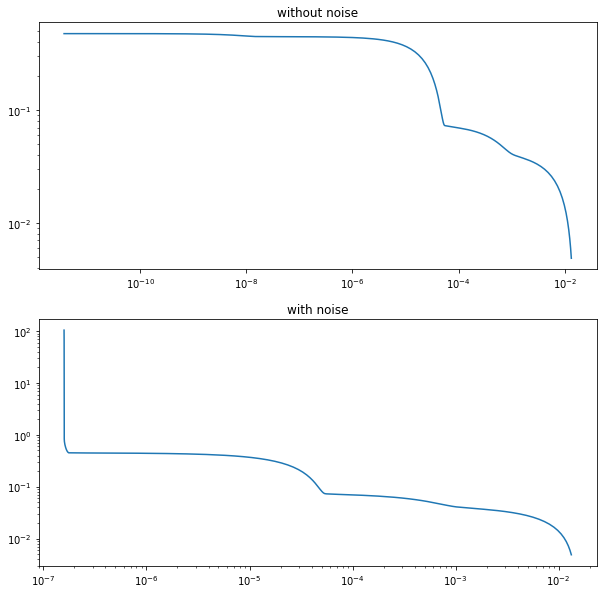

In [9]:
k = 2
plot_Lcurve(Q[k, :], F[:, k], nF[:, k], N, M, tau, delta, min_al)

* make hat Q with best alpha of each data

In [10]:
hatQ_arr = []
for i in range(M):
    hatQ_arr.append(sol_Tik(alpha_target[i], T, F[:, i]))
    
hatQ = np.array(hatQ_arr)
np.savetxt('hatQ.txt', hatQ.T, fmt='%8f', delimiter = ',', header='')

In [11]:
arr = []
for i in range(M):
    arr.append(i+1)

In [12]:
#load data
#column name에 data가 들어가있기 때문에 "names = arr" 로 처리해 줍니다. arr은 1 ~ len(F)의 숫자가 담겨있습니다.
dataF = pd.read_csv('C:/Users/Administrator/F.txt', sep = ',', names = arr)
dataQ = pd.read_csv('C:/Users/Administrator/Q.txt', sep = ',', names = arr)
#dataQ = pd.read_csv('C:/Users/Administrator/hatQ.txt', sep = ',', names = arr)
data_nF = pd.read_csv('C:/Users/Administrator/nF.txt', sep = ',', names = arr)

In [13]:
def make_arr(A):
    arA = []
    for j in range(len(A.iloc[0, :])):
        arA1 = []
        for i in range(len(A.iloc[:,0])):
            tmpA = A.iloc[:,j][i]
            arA1.append(tmpA)
        arA.append(arA1)
    return arA

#make array
arrF = make_arr(dataF)
dataF = np.array(arrF)

arrQ = make_arr(dataQ)
dataQ = np.array(arrQ)

arr_nF = make_arr(data_nF)
data_nF = np.array(arr_nF)

alpha_target = np.array(alpha_target)

In [14]:
import math
train_size = math.floor(len(dataF)*0.6) # train : 60%
val_size = math.floor(len(dataF)*0.2) #val : 20%
test_size = math.floor(len(dataF)*0.2) #test : 20%
#generate F_data, F_val, F_test
F_data = dataF[:train_size, :]
F_val = dataF[train_size:(val_size + train_size), :]
F_test = dataF[(val_size + train_size):(val_size + train_size + test_size), :]

#generate Q_data, Q_val, Q_test
Q_data = dataQ[:train_size, :]
Q_val = dataQ[train_size:(val_size + train_size), :]
Q_test = dataQ[(val_size + train_size):(val_size + train_size + test_size), :]

#generate nF_data, nF_val, nF_test
nF_data = data_nF[:train_size, :]
nF_val = data_nF[train_size:(val_size + train_size), :]
nF_test = data_nF[(val_size + train_size):(val_size + train_size + test_size), :]

#Q+F
QF_data = np.concatenate((Q_data, F_data), axis = 1)
QF_val = np.concatenate((Q_val, F_val), axis = 1)
QF_test = np.concatenate((Q_test, F_test), axis = 1)

#Q+nF
QnF_data = np.concatenate((Q_data, nF_data), axis = 1)
QnF_val = np.concatenate((Q_val, nF_val), axis = 1)
QnF_test = np.concatenate((Q_test, nF_test), axis = 1)

#alpha_target
alpha_target_data = alpha_target[:train_size]
alpha_target_val = alpha_target[train_size:(val_size + train_size)]
alpha_target_test = alpha_target[(val_size + train_size):(val_size + train_size + test_size)]

print(f'splitted Q : {Q_data.shape}, {Q_test.shape}, {Q_val.shape}')
print(f'splitted F : {F_data.shape}, {F_test.shape}, {F_val.shape}')
print(f'splitted nF : {nF_data.shape}, {nF_test.shape}, {nF_val.shape}\n')

print(f'splitted QF : {QF_data.shape}, {QF_test.shape}, {QF_val.shape}')
print(f'splitted QnF : {QnF_data.shape}, {QnF_test.shape}, {QnF_val.shape}\n')
print(f'splitted alpha : {alpha_target_data.shape}, {alpha_target_test.shape}, {alpha_target_val.shape}')

splitted Q : (30000, 10), (10000, 10), (10000, 10)
splitted F : (30000, 10), (10000, 10), (10000, 10)
splitted nF : (30000, 10), (10000, 10), (10000, 10)

splitted QF : (30000, 20), (10000, 20), (10000, 20)
splitted QnF : (30000, 20), (10000, 20), (10000, 20)

splitted alpha : (30000,), (10000,), (10000,)


In [15]:
import tensorflow as tf
from tensorflow import keras

model = keras.models.Sequential() #Sequential

model.add(keras.layers.Dense(input_dim = 2*N, units = 10, activation= "tanh",kernel_initializer ="HeNormal" )) 
model.add(keras.layers.Dense(20, activation= "tanh")) 
model.add(keras.layers.Dense(50, activation= "tanh"))  
model.add(keras.layers.Dense(100, activation= "tanh")) 
model.add(keras.layers.Dense(120, activation= "tanh")) 
model.add(keras.layers.Dense(50, activation= "tanh"))
model.add(keras.layers.Dense(1, activation= "tanh"))

In [16]:
with tf.device('/GPU:0'):
    F_train = tf.constant(F_data)
    Q_train = tf.constant(Q_data)
    nF_train = tf.constant(nF_data)
    QF_train = tf.constant(QF_data)
    alpha_target_train = tf.constant(alpha_target_data)
    
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=0, verbose=0,
    mode='auto', baseline=None, restore_best_weights=False
)

In [17]:
start_vect=time.time()

model.compile(loss = "mse",
              optimizer = "ADAM",
              metrics = ["accuracy"])
history = model.fit(x = QF_train, y = alpha_target_train, validation_data=(QF_val, alpha_target_val),epochs = 500)


print("training Runtime: %0.2f Minutes"%((time.time() - start_vect)/60))

Epoch 1/500
938/938 [==============================] - 1s 590us/step - loss: 1.1203e-04 - accuracy: 0.0000e+00 - val_loss: 8.3331e-07 - val_accuracy: 0.0000e+00
Epoch 2/500
938/938 [==============================] - 0s 503us/step - loss: 4.2557e-06 - accuracy: 0.0000e+00 - val_loss: 6.0062e-06 - val_accuracy: 0.0000e+00
Epoch 3/500
938/938 [==============================] - 0s 504us/step - loss: 4.0107e-06 - accuracy: 0.0000e+00 - val_loss: 1.0683e-05 - val_accuracy: 0.0000e+00
Epoch 4/500
938/938 [==============================] - 0s 504us/step - loss: 4.7108e-06 - accuracy: 0.0000e+00 - val_loss: 4.6003e-08 - val_accuracy: 0.0000e+00
Epoch 5/500
938/938 [==============================] - 0s 504us/step - loss: 8.8583e-07 - accuracy: 0.0000e+00 - val_loss: 1.8349e-07 - val_accuracy: 0.0000e+00
Epoch 6/500
938/938 [==============================] - 0s 505us/step - loss: 1.3397e-06 - accuracy: 0.0000e+00 - val_loss: 1.4045e-08 - val_accuracy: 0.0000e+00
Epoch 7/500
938/938 [=============

In [19]:
result = model.evaluate(QF_test, alpha_target_test)

313/313 [==============================] - 0s 259us/step - loss: 2.5668e-11 - accuracy: 0.0000e+00


In [24]:
alpha_target

array([7.05480231e-16, 5.09413801e-10, 3.35160265e-08, ...,
       2.05651231e-09, 2.05651231e-09, 5.21400829e-09])